# Unnati 

In [1]:
!pip install numpy

In [2]:
!pip install numpy matplotlib seaborn

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [3]:
import pandas as pd
import numpy as np
import math
import json
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.utils.multiclass import unique_labels

%matplotlib inline

## Analyze portfolio data

In [4]:
portfolio = pd.read_json('portfolio.json', orient='records', lines=True)
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [5]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [6]:
portfolio.isnull().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

In [7]:
portfolio.rename(columns={'id': 'offer_id'}, inplace=True)

In [8]:
#check different types of offers
portfolio.groupby(['offer_type'])['offer_id'].count()

offer_type
bogo             4
discount         4
informational    2
Name: offer_id, dtype: int64

In [9]:
portfolio['offer_type'].unique()

array(['bogo', 'informational', 'discount'], dtype=object)

In [10]:
# Convert time feature from days to hours
portfolio['duration'] = portfolio['duration']*24

# Make separate columns for values in feature channels list
portfolio['web'] = portfolio['channels'].apply(lambda x: int(1) if 'web' in x else int(0))
portfolio['email'] = portfolio['channels'].apply(lambda x: int(1) if 'email' in x else int(0))
portfolio['mobile'] = portfolio['channels'].apply(lambda x: int(1) if 'mobile' in x else int(0))
portfolio['social'] = portfolio['channels'].apply(lambda x: int(1) if 'social' in x else int(0))

# Drop channels column
portfolio.drop(columns=['channels'],axis=1, inplace=True)

# OneHotEncoding fetaure offer_type
portfolio = pd.get_dummies(portfolio, columns=['offer_type'], prefix='', prefix_sep='')

# Re-order columns of portfolio dataframe
col_order = ['offer_id', 'difficulty', 'duration', 'reward', 'bogo', 'discount', 'informational', 'web', 'email',\
             'mobile', 'social']
portfolio = portfolio.reindex(col_order, axis=1)

# Print portfolio dataframe
portfolio

,offer_id,difficulty,duration,reward,bogo,discount,informational,web,email,mobile,social
0,ae264e3637204a6fb9bb56bc8210ddfd,10,168,10,1,0,0,0,1,1,1
1,4d5c57ea9a6940dd891ad53e9dbe8da0,10,120,10,1,0,0,1,1,1,1
2,3f207df678b143eea3cee63160fa8bed,0,96,0,0,0,1,1,1,1,0
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,168,5,1,0,0,1,1,1,0
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,240,5,0,1,0,1,1,0,0
5,2298d6c36e964ae4a3e7e9706d1fb8c2,7,168,3,0,1,0,1,1,1,1
6,fafdcd668e3743c1bb461111dcafc2a4,10,240,2,0,1,0,1,1,1,1
7,5a8bc65990b245e5a138643cd4eb9837,0,72,0,0,0,1,0,1,1,1
8,f19421c1d4aa40978ebb69ca19b0e20d,5,120,5,1,0,0,1,1,1,1
9,2906b810c7d4411798c6938adc9daaa5,10,168,2,0,1,0,1,1,1,0


In [11]:
portfolio.shape

(10, 11)

In [12]:
portfolio.columns

Index(['offer_id', 'difficulty', 'duration', 'reward', 'bogo', 'discount',
       'informational', 'web', 'email', 'mobile', 'social'],
      dtype='object')

## Analyze profile data

In [13]:
# Load profile data 
profile = pd.read_json('profile.json', orient='records', lines=True)
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [14]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [15]:
profile.shape

(17000, 5)

In [16]:
profile.isnull().sum(0)

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [17]:
len(profile['id'].unique())

17000

In [18]:
profile.rename(columns={'id': 'customer_id'}, inplace=True)

In [19]:
len(profile['customer_id'].unique())

17000

In [20]:
profile['gender'].value_counts().sort_values(ascending=False)

M    8484
F    6129
O     212
Name: gender, dtype: int64

In [21]:
profile['age'].value_counts().sort_index(ascending=False)

118    2175
101       5
100      12
99        5
98        5
       ... 
22      131
21      140
20      135
19      135
18       70
Name: age, Length: 85, dtype: int64

In [22]:
profile_age_118 = profile[profile['age'] == 118]
profile_age_118.head()

,gender,age,customer_id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN


In [23]:
profile_age_118.shape[0]

2175

In [24]:
print(profile_age_118['gender'].unique()[0])
print(profile_age_118['gender'].shape[0])

None
2175


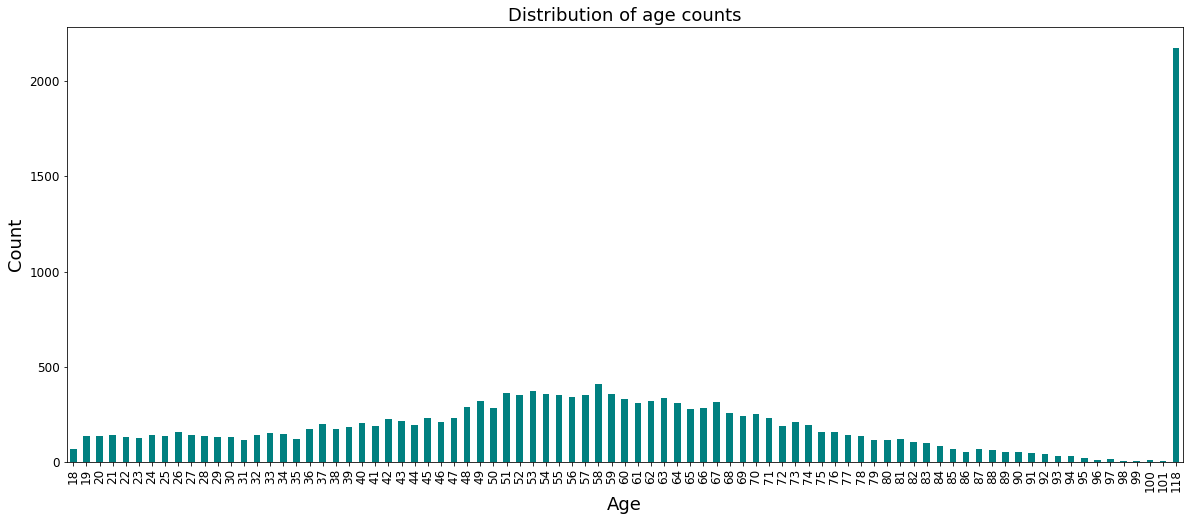

In [25]:
profile['age'].value_counts().sort_index(ascending=True).plot.bar(figsize=(20,8), fontsize=12,color='teal');
plt.xlabel('Age', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.title('Distribution of age counts', fontsize=18)
plt.show()

In [26]:
profile.drop(index=profile_age_118.index, inplace=True)
profile.head()

,gender,age,customer_id,became_member_on,income
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0


In [27]:
profile.shape

(14825, 5)

In [28]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               14825 non-null  int64  
 2   customer_id       14825 non-null  object 
 3   became_member_on  14825 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 694.9+ KB


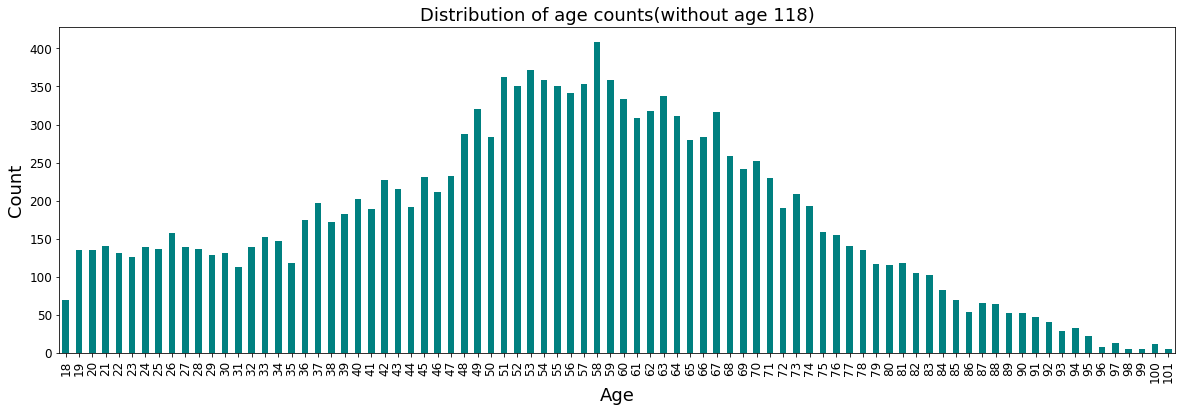

In [29]:
profile['age'].value_counts().sort_index(ascending=True).plot.bar(figsize=(20,6), fontsize=12,color='teal');
plt.xlabel('Age', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.title('Distribution of age counts(without age 118)', fontsize=18)
plt.show()

In [30]:
profile['age_bins'] = pd.cut(profile['age'], bins=range(10,120,10), right=False)
profile['age_by_decade'] = pd.cut(profile['age'], bins=range(10,120,10),\
                                  right=False, labels=['10s','20s', '30s', '40s', '50s','60s', '70s', '80s', '90s', '100s'])

In [31]:
profile.head()

,gender,age,customer_id,became_member_on,income,age_bins,age_by_decade
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,"[50, 60)",50s
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,"[70, 80)",70s
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0,"[60, 70)",60s
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0,"[60, 70)",60s
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0,"[50, 60)",50s


In [32]:
profile['age_bins'].unique()

[[50, 60), [70, 80), [60, 70), [20, 30), [40, 50), [30, 40), [90, 100), [80, 90), [10, 20), [100, 110)]
Categories (10, interval[int64, left]): [[10, 20) < [20, 30) < [30, 40) < [40, 50) ... [70, 80) < [80, 90) < [90, 100) < [100, 110)]

In [33]:
profile['age_by_decade'].unique()

['50s', '70s', '60s', '20s', '40s', '30s', '90s', '80s', '10s', '100s']
Categories (10, object): ['10s' < '20s' < '30s' < '40s' ... '70s' < '80s' < '90s' < '100s']

In [34]:
profile['age_by_decade'].value_counts().sort_index()

10s      205
20s     1369
30s     1526
40s     2309
50s     3541
60s     2991
70s     1782
80s      831
90s      254
100s      17
Name: age_by_decade, dtype: int64

In [35]:
profile.drop(columns=['age', 'age_bins'], inplace=True)
profile.head()

,gender,customer_id,became_member_on,income,age_by_decade
1,F,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,50s
3,F,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,70s
5,M,e2127556f4f64592b11af22de27a7932,20180426,70000.0,60s
8,M,389bc3fa690240e798340f5a15918d5c,20180209,53000.0,60s
12,M,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0,50s


In [36]:
profile = pd.get_dummies(profile, columns=['age_by_decade'], prefix='age', prefix_sep='_')
profile.head()

,gender,customer_id,became_member_on,income,age_10s,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_80s,age_90s,age_100s
1,F,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,0,0,0,0,1,0,0,0,0,0
3,F,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,0,0,0,0,0,0,1,0,0,0
5,M,e2127556f4f64592b11af22de27a7932,20180426,70000.0,0,0,0,0,0,1,0,0,0,0
8,M,389bc3fa690240e798340f5a15918d5c,20180209,53000.0,0,0,0,0,0,1,0,0,0,0
12,M,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0,0,0,0,0,1,0,0,0,0,0


#### Analyze feature 'became_member_on'

In [37]:
type(profile['became_member_on'])

pandas.core.series.Series

In [38]:
type(pd.to_datetime(profile['became_member_on'],format='%Y%m%d').dt)

pandas.core.indexes.accessors.DatetimeProperties

In [39]:
pd.to_datetime(profile['became_member_on'],format='%Y%m%d').dt.year.value_counts().sort_index(ascending=True)

2013     274
2014     662
2015    1597
2016    3024
2017    5599
2018    3669
Name: became_member_on, dtype: int64

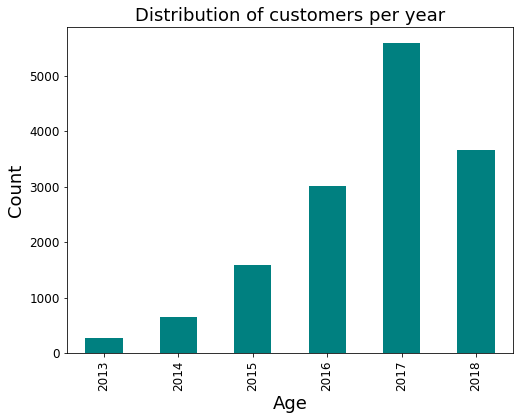

In [40]:
pd.to_datetime(profile['became_member_on'],\
               format='%Y%m%d').dt.year.value_counts().sort_index(ascending=True).plot.bar(figsize=(8,6),\
                                                                                           fontsize=12,color='teal');
plt.xlabel('Age', fontsize=18) #change age
plt.ylabel('Count', fontsize=18)
plt.title('Distribution of customers per year', fontsize=18)
plt.show()

In [41]:
pd.to_datetime(profile['became_member_on'],format='%Y%m%d').dt.month.value_counts().sort_values(ascending=False)

8     1395
10    1386
12    1372
1     1327
9     1299
11    1268
7     1189
5     1152
4     1145
3     1145
6     1105
2     1042
Name: became_member_on, dtype: int64

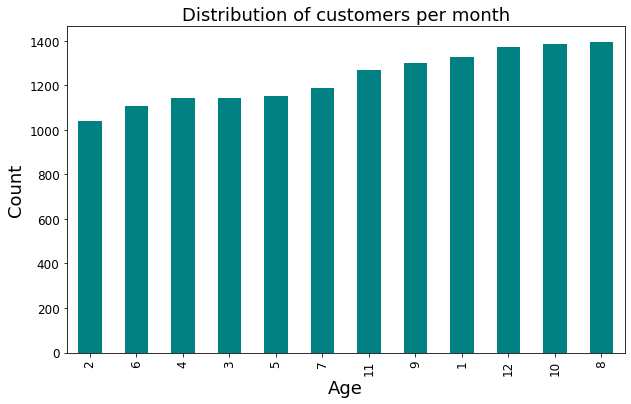

In [42]:
pd.to_datetime(profile['became_member_on'],\
               format='%Y%m%d').dt.month.value_counts().sort_values(ascending=True).plot.bar(figsize=(10,6),\
                                                                                           fontsize=12,color='teal');
plt.xlabel('Age', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.title('Distribution of customers per month', fontsize=18)
plt.show()

In [43]:
# Create feature 'membership_tenure' of customers from feature 'became_member_on'
profile['membership_tenure'] = (datetime.today().date() - pd.to_datetime(profile['became_member_on'],\
                                                                     format='%Y%m%d').dt.date).dt.days

# Create feature 'membership_year' in which customer became member from feature 'became_member_on'
profile['membership_year'] = pd.to_datetime(profile['became_member_on'],format='%Y%m%d').dt.year

# Create feature 'membership_month' in which customer became member from feature 'became_member_on'
profile['membership_month'] = pd.to_datetime(profile['became_member_on'],format='%Y%m%d').dt.month

# Drop feature 'became_member_on'
profile.drop(columns=['became_member_on'], axis=1, inplace=True)
profile.head()

,gender,customer_id,income,age_10s,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_80s,age_90s,age_100s,membership_tenure,membership_year,membership_month
1,F,0610b486422d4921ae7d2bf64640c50b,112000.0,0,0,0,0,1,0,0,0,0,0,1791,2017,7
3,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,0,0,0,0,0,0,1,0,0,0,1858,2017,5
5,M,e2127556f4f64592b11af22de27a7932,70000.0,0,0,0,0,0,1,0,0,0,0,1506,2018,4
8,M,389bc3fa690240e798340f5a15918d5c,53000.0,0,0,0,0,0,1,0,0,0,0,1582,2018,2
12,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,0,0,0,0,1,0,0,0,0,0,1672,2017,11


#### Analyze feature 'gender'

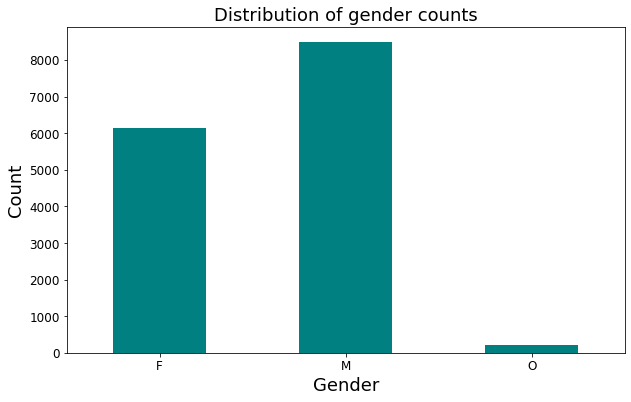

In [44]:
# Plot distribution of gender in profile dataframe
profile['gender'].value_counts().sort_index(ascending=True).plot.bar(figsize=(10,6), fontsize=12,color='teal');
plt.xlabel('Gender', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.xticks(rotation='horizontal')
plt.title('Distribution of gender counts', fontsize=18)
plt.show()

In [45]:
# Create gender_by_year_df dataframe to be used to create visualization
gender_by_year_df = pd.DataFrame(profile.groupby(['membership_year'])['gender'].value_counts())
gender_by_year_df.rename(columns = {'gender': 'gender_count'}, inplace=True)
gender_by_year_df.reset_index(inplace=True)
gender_by_year_df

,membership_year,gender,gender_count
0,2013,M,197
1,2013,F,74
2,2013,O,3
3,2014,M,520
4,2014,F,138
5,2014,O,4
6,2015,M,905
7,2015,F,663
8,2015,O,29
9,2016,F,1509


#### Analyze feature 'income'

In [46]:
np.sort(profile['income'].unique())

array([ 30000.,  31000.,  32000.,  33000.,  34000.,  35000.,  36000.,
        37000.,  38000.,  39000.,  40000.,  41000.,  42000.,  43000.,
        44000.,  45000.,  46000.,  47000.,  48000.,  49000.,  50000.,
        51000.,  52000.,  53000.,  54000.,  55000.,  56000.,  57000.,
        58000.,  59000.,  60000.,  61000.,  62000.,  63000.,  64000.,
        65000.,  66000.,  67000.,  68000.,  69000.,  70000.,  71000.,
        72000.,  73000.,  74000.,  75000.,  76000.,  77000.,  78000.,
        79000.,  80000.,  81000.,  82000.,  83000.,  84000.,  85000.,
        86000.,  87000.,  88000.,  89000.,  90000.,  91000.,  92000.,
        93000.,  94000.,  95000.,  96000.,  97000.,  98000.,  99000.,
       100000., 101000., 102000., 103000., 104000., 105000., 106000.,
       107000., 108000., 109000., 110000., 111000., 112000., 113000.,
       114000., 115000., 116000., 117000., 118000., 119000., 120000.])

In [47]:
profile['income'].value_counts().sort_index()

30000.0      88
31000.0     223
32000.0     216
33000.0     213
34000.0     199
           ... 
116000.0     46
117000.0     32
118000.0     58
119000.0     54
120000.0     13
Name: income, Length: 91, dtype: int64

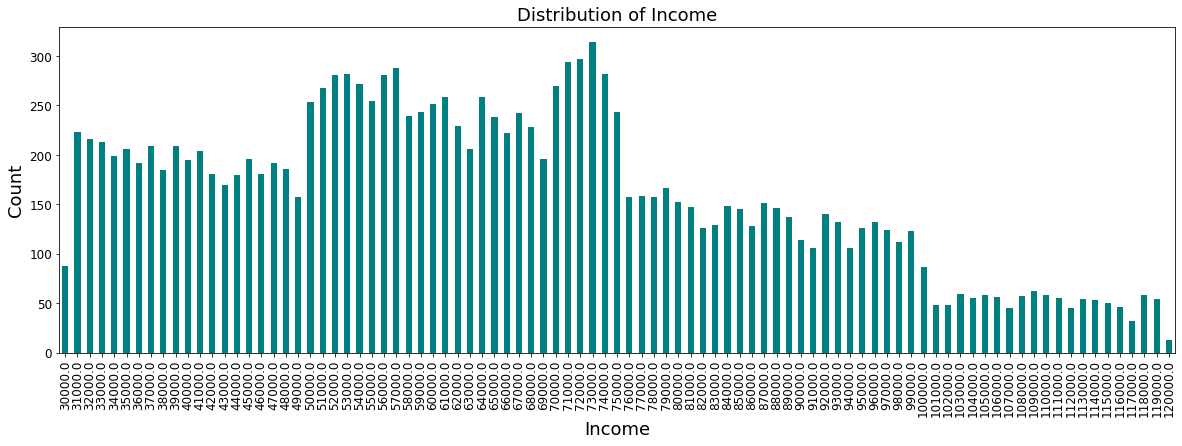

In [48]:
# Plot distribution of feature 'income' in profile dataframe
profile['income'].value_counts().sort_index(ascending=True).plot.bar(figsize=(20,6), fontsize=12,color='teal');
plt.xlabel('Income', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.xticks(rotation='vertical')
plt.title('Distribution of Income', fontsize=18)
plt.show()

In [49]:
# OneHotEncoding feature 'membership_year'
profile = pd.get_dummies(profile, columns=['membership_year'], prefix='', prefix_sep='')

# OneHotEncoding feature 'membership_month'
profile = pd.get_dummies(profile, columns=['membership_month'], prefix='month', prefix_sep='_')

# OneHotEncoding feature 'gender'
profile = pd.get_dummies(profile, columns=['gender'], prefix='', prefix_sep='')

profile.head()

,customer_id,income,age_10s,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_80s,...,month_6,month_7,month_8,month_9,month_10,month_11,month_12,F,M,O
1,0610b486422d4921ae7d2bf64640c50b,112000.0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0
3,78afa995795e4d85b5d9ceeca43f5fef,100000.0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
5,e2127556f4f64592b11af22de27a7932,70000.0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
8,389bc3fa690240e798340f5a15918d5c,53000.0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
12,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,1,0


In [50]:
# Convert feature 'income' into 'income_by_range' which would be helpful in determining
# if a particular income range is influenced more by an offer
profile['income_by_range'] = pd.cut(profile['income'], bins=range(30000,140000,10000), right=False,\
                                    labels=['30ths','40ths', '50ths', '60ths', '70ths','80ths', '90ths',\
                                            '100ths', '110ths', '120ths'])
profile.head()

,customer_id,income,age_10s,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_80s,...,month_7,month_8,month_9,month_10,month_11,month_12,F,M,O,income_by_range
1,0610b486422d4921ae7d2bf64640c50b,112000.0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,1,0,0,110ths
3,78afa995795e4d85b5d9ceeca43f5fef,100000.0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,100ths
5,e2127556f4f64592b11af22de27a7932,70000.0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,70ths
8,389bc3fa690240e798340f5a15918d5c,53000.0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,50ths
12,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,1,0,50ths


In [51]:
profile.drop(columns=['income'], inplace=True)

In [52]:
profile = pd.get_dummies(profile, columns=['income_by_range'], prefix='income', prefix_sep='_')
profile.head()

,customer_id,age_10s,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_80s,age_90s,...,income_30ths,income_40ths,income_50ths,income_60ths,income_70ths,income_80ths,income_90ths,income_100ths,income_110ths,income_120ths
1,0610b486422d4921ae7d2bf64640c50b,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,78afa995795e4d85b5d9ceeca43f5fef,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
5,e2127556f4f64592b11af22de27a7932,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
8,389bc3fa690240e798340f5a15918d5c,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
12,2eeac8d8feae4a8cad5a6af0499a211d,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [53]:
profile_col_order = ['customer_id', 'membership_tenure', 'F', 'M', 'O',\
                     'age_10s', 'age_20s', 'age_30s', 'age_40s', 'age_50s',\
                     'age_60s', 'age_70s', 'age_80s', 'age_90s', 'age_100s',\
                     '2013', '2014', '2015', '2016', '2017', '2018',\
                     'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',\
                     'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',\
                     'income_30ths', 'income_40ths', 'income_50ths','income_60ths', 'income_70ths',\
                     'income_80ths', 'income_90ths','income_100ths', 'income_110ths', 'income_120ths']

profile = profile.reindex(profile_col_order, axis=1)
profile.head()

,customer_id,membership_tenure,F,M,O,age_10s,age_20s,age_30s,age_40s,age_50s,...,income_30ths,income_40ths,income_50ths,income_60ths,income_70ths,income_80ths,income_90ths,income_100ths,income_110ths,income_120ths
1,0610b486422d4921ae7d2bf64640c50b,1791,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,78afa995795e4d85b5d9ceeca43f5fef,1858,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5,e2127556f4f64592b11af22de27a7932,1506,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
8,389bc3fa690240e798340f5a15918d5c,1582,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
12,2eeac8d8feae4a8cad5a6af0499a211d,1672,0,1,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0


In [54]:
profile.shape

(14825, 43)

## Analyze transcript data

In [55]:
# Load transcript data
transcript = pd.read_json('transcript.json', orient='records', lines=True)
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [56]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [57]:
transcript.shape

(306534, 4)

In [58]:
transcript.isnull().sum()

person    0
event     0
value     0
time      0
dtype: int64

In [59]:
transcript.rename(columns={'person': 'customer_id'}, inplace=True)

In [60]:
id_age_118 = profile_age_118['customer_id'].unique().tolist()
print(transcript['customer_id'].isin(id_age_118).value_counts())

False    272762
True      33772
Name: customer_id, dtype: int64


In [61]:
# Percentage of observations in transcript dataframe with customers having age 118
round((transcript['customer_id'].isin(id_age_118).sum()/transcript.shape[0])*100,2)

11.02

In [62]:
# Remove observations having customers with age 118 from transcript dataframe
transcript = transcript[~transcript['customer_id'].isin(id_age_118)]
transcript.head()

,customer_id,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
5,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0


In [63]:
transcript.shape

(272762, 4)

In [64]:
transcript['event'].value_counts()

transaction        123957
offer received      66501
offer viewed        49860
offer completed     32444
Name: event, dtype: int64

In [65]:
round((transcript['event'].value_counts()/transcript['event'].value_counts().sum())*100,2)

transaction        45.45
offer received     24.38
offer viewed       18.28
offer completed    11.89
Name: event, dtype: float64

In [66]:
# Calculate percentage of transaction and offer events
event_transaction = transcript['event'].value_counts()[0]
event_offers = transcript['event'].value_counts()[1:].sum()
event_total = transcript['event'].shape[0]

print('Percentage of transaction events are: {}%'.format(round((event_transaction/event_total)*100,2)))
print('Percentage of offers events are: {}%'.format(round((event_offers/event_total)*100,2)))

Percentage of transaction events are: 45.45%
Percentage of offers events are: 54.55%


In [67]:
# Create dataframe offers_df containing only offers events and transaction_df containing only transaction event
# Create a list of offer event types
offer_event_list = ['offer received', 'offer viewed', 'offer completed']

# Find index where feature 'event' is 'offer received', 'offer viewed', 'offer completed'
offer_index = transcript[transcript['event'].isin(offer_event_list)].index

# Find index where feature event is 'transaction'
transaction_index = transcript[~transcript['event'].isin(offer_event_list)].index

# Create offers_df
offers_df = transcript.loc[offer_index,:]

# Create transaction_df
transaction_df = transcript.loc[transaction_index,:]

In [68]:
offers_df['event'].unique()

array(['offer received', 'offer viewed', 'offer completed'], dtype=object)

In [69]:
transaction_df['event'].unique()

array(['transaction'], dtype=object)

In [70]:
# Create function to retrieve offer_id from feature value
def func_value_offer_id(x):
    for k,v in x.items():
        if k in ['offer id','offer_id']:
            return str(v)
        elif k not in ['offer id','offer_id', 'reward']:
            print('key {} not in dict'.format(k))

In [71]:
offers_df.loc[:,'offer_id'] = offers_df['value'].apply(func_value_offer_id)

In [72]:
offers_df.head()

,customer_id,event,value,time,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5
5,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0,f19421c1d4aa40978ebb69ca19b0e20d
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0,3f207df678b143eea3cee63160fa8bed
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [73]:
# Create another column 'offer_type' with respect to feature 'offer_id'
offers_df['offer_type'] = offers_df['offer_id'].copy()



offers_df['offer_type'].replace(['ae264e3637204a6fb9bb56bc8210ddfd','4d5c57ea9a6940dd891ad53e9dbe8da0',\
                                 '9b98b8c7a33c4b65b9aebfe6a799e6d9','f19421c1d4aa40978ebb69ca19b0e20d'],\
                                 'bogo', inplace=True)

offers_df['offer_type'].replace(['0b1e1539f2cc45b7b9fa7c272da2e1d7','2298d6c36e964ae4a3e7e9706d1fb8c2',\
                                 'fafdcd668e3743c1bb461111dcafc2a4','2906b810c7d4411798c6938adc9daaa5'],\
                                 'discount', inplace=True)

offers_df['offer_type'].replace(['3f207df678b143eea3cee63160fa8bed','5a8bc65990b245e5a138643cd4eb9837'],\
                                 'informational', inplace=True)

offers_df.head()

,customer_id,event,value,time,offer_id,offer_type
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,discount
5,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0,f19421c1d4aa40978ebb69ca19b0e20d,bogo
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0,3f207df678b143eea3cee63160fa8bed,informational
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount


In [74]:
offers_df.groupby(['offer_type', 'event'])['customer_id'].count()

offer_type     event          
bogo           offer completed    15258
               offer received     26537
               offer viewed       22039
discount       offer completed    17186
               offer received     26664
               offer viewed       18461
informational  offer received     13300
               offer viewed        9360
Name: customer_id, dtype: int64

In [75]:
# Transform offers_df
# Drop feature value as it is not required now and drop feature offer_type as that information is also in portfolio dataframe
# as well
offers_df.drop(columns=['value', 'offer_type'], inplace=True)

# OneHotEncoding feature 'event'
offers_df = pd.get_dummies(offers_df, columns=['event'], prefix='', prefix_sep='')

# Change column names
offers_df.rename(columns = {'offer received': 'offer_recd',
                            'offer viewed': 'offer_view',
                            'offer completed': 'offer_comp'}, inplace=True)

# Re-order columns of offers_df dataframe
offers_df_col_order = ['customer_id', 'offer_id', 'time', 'offer_recd', 'offer_view', 'offer_comp']

offers_df = offers_df.reindex(offers_df_col_order, axis=1)
offers_df.head()

,customer_id,offer_id,time,offer_recd,offer_view,offer_comp
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,0,1,0,0
5,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,0,1,0,0
7,2eeac8d8feae4a8cad5a6af0499a211d,3f207df678b143eea3cee63160fa8bed,0,1,0,0
8,aa4862eba776480b8bb9c68455b8c2e1,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,0


In [76]:
# Transform transaction_df
# Create column 'amount'
transaction_df.loc[:,'amount'] = transaction_df['value'].apply(lambda x: x['amount'])

# Drop feature 'event' & 'value'
transaction_df.drop(columns=['event', 'value'], inplace=True)
transaction_df.head()

,customer_id,time,amount
12654,02c083884c7d45b39cc68e1314fec56c,0,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56
12659,54890f68699049c2a04d415abc25e717,0,13.23
12670,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51
12671,fe97aa22dd3e48c8b143116a8403dd52,0,18.97


In [77]:
# Install progressbar in the current Jupyter kernel with pip install
import sys
!{sys.executable} -m pip install progressbar
from progressbar import ProgressBar, Percentage, Bar, RotatingMarker, ETA, FileTransferSpeed

In [78]:
# Create function to combine transaction, demographic and offer data
def create_combined_data(portfolio, profile, offers_df, transaction_df, combined_data_path='./data/combined_data.csv'):
    '''Create a combined dataframe from the transaction, demographic and offer data:
    INPUT:
        portfolio - (dataframe),offer metadata
        profile - (dataframe),customer demographic data
        offers_df - (dataframe), offers data for customers
        transaction_df - (dataframe), transaction data for customers
        combined_data_path - (filepath), path of a .csv file
    OUTPUT:
        combined_data_df - (dataframe),combined data from transaction, demographic and offer data
    '''
    if os.path.exists(combined_data_path):
        print('Reading combined data .csv file')
        combined_data_df = pd.read_csv(combined_data_path)
        return combined_data_df
    else:
        combined_data = [] # Initialize empty list for combined data
        customer_id_list = offers_df['customer_id'].unique().tolist() # List of unique customers in offers_df
        
        # Create widget for progress bar
        widgets = [Percentage(), ' ', Bar(marker=RotatingMarker()), ' ', ETA(), ' ', FileTransferSpeed()]
        # Create and start progressbar
        pbar = ProgressBar(widgets=widgets, maxval=len(customer_id_list)).start()

        # Iterate over each customer
        for idx,cust_id in enumerate(customer_id_list):
            # Select a specific customer profile
            cust_profile = profile[profile['customer_id'] == cust_id] 
            # Select offers for a specific customer
            cust_offers_df = offers_df[offers_df['customer_id'] == cust_id]
            # Select transactions for a specific customer
            cust_transaction_df = transaction_df[transaction_df['customer_id'] == cust_id]
            # Select offers received by a specific customer
            cust_offers_recd_df = cust_offers_df[cust_offers_df['offer_recd'] == 1]
            # Select offers viewed by a specific customer
            cust_offers_view_df = cust_offers_df[cust_offers_df['offer_view'] == 1]
            # Select offers completed by a specific customer
            cust_offers_comp_df = cust_offers_df[cust_offers_df['offer_comp'] == 1]
            
            # Iterate over each offer received by a customer
            cust_offers_response = [] # Initialize empty list for a customer records
            
            for off_id in cust_offers_recd_df['offer_id'].values.tolist():
                # Look-up duration of a particular offer_id
                duration = portfolio.loc[portfolio['offer_id'] == off_id, 'duration'].values[0]
                # Look-up the time when offer was received
                off_recd_time = cust_offers_recd_df.loc[cust_offers_recd_df['offer_id'] == off_id, 'time'].values[0]
                # Calculate the time when the offer end
                off_end_time = off_recd_time + duration
                #Initialize a boolean array that determines if the customer viewed an offer between offer period
                offers_viewed = np.logical_and(cust_offers_view_df['time'] >= off_recd_time,\
                                               cust_offers_view_df['time'] <= off_end_time)
                
                # Check if the offer type is 'bogo' or 'discount'
                if (portfolio[portfolio['offer_id'] == off_id]['bogo'].values[0] == 1 or\
                    portfolio[portfolio['offer_id'] == off_id]['discount'].values[0] == 1):
                    #Initialize a boolean array that determines if the customer completed an offer between offer period
                    offers_comp = np.logical_and(cust_offers_comp_df['time'] >= off_recd_time,\
                                                 cust_offers_comp_df['time'] <= off_end_time)
                    
                    #Initialize a boolean array that selects customer transctions between offer period
                    cust_tran_within_period = cust_transaction_df[np.logical_and(cust_transaction_df['time'] >= off_recd_time,\
                                                                                 cust_transaction_df['time'] <= off_end_time)]
                    
                    # Determine if the customer responded to an offer(bogo or discount) or not
                    cust_response = np.logical_and(offers_viewed.sum() > 0, offers_comp.sum() > 0) and\
                                                    (cust_tran_within_period['amount'].sum() >=\
                                                     portfolio[portfolio['offer_id'] == off_id]['difficulty'].values[0])
                
                # Check if the offer type is 'informational'
                elif portfolio[portfolio['offer_id'] == off_id]['informational'].values[0] == 1:
                    #Initialize a boolean array that determines if the customer made any transctions between offer period
                    cust_info_tran = np.logical_and(cust_transaction_df['time'] >= off_recd_time,\
                                                    cust_transaction_df['time'] <= off_end_time)                   
                    
                    # Determine if the customer responded to an offer(informational) or not
                    cust_response = offers_viewed.sum() > 0 and cust_info_tran.sum() > 0                  
                
                    #Initialize a boolean array that selects customer transctions between offer period
                    cust_tran_within_period = cust_transaction_df[np.logical_and(cust_transaction_df['time'] >= off_recd_time,\
                                                                                 cust_transaction_df['time'] <= off_end_time)]
                
                # Initialize a dictionary for a customer with required information for a particular offer
                cust_rec = {'cust_response': int(cust_response),
                            'time': off_recd_time,
                            'total_amount': cust_tran_within_period['amount'].sum()}
                cust_rec.update(profile[profile['customer_id'] == cust_id].squeeze().to_dict())
                cust_rec.update(portfolio[portfolio['offer_id'] == off_id].squeeze().to_dict())
                
                # Add the dictionary to list for combined_data
                cust_offers_response.append(cust_rec)
            
            # Add the dictionaries from cust_offers_response list to combined_data list
            combined_data.extend(cust_offers_response)
            
            # Update progressbar
            pbar.update(idx+1)
        
        # Convert combined_data list to dataframe
        combined_data_df = pd.DataFrame(combined_data)
        
        # Re-order columns of combined_data_df
        combined_data_df_col_order = ['customer_id', 'offer_id', 'time']

        port_ls = portfolio.columns.tolist()
        port_ls.remove('offer_id')
        pro_ls = profile.columns.tolist()
        pro_ls.remove('customer_id')
        combined_data_df_col_order.extend(port_ls)
        combined_data_df_col_order.extend(pro_ls)
        combined_data_df_col_order.extend(['total_amount', 'cust_response'])
        
        combined_data_df = combined_data_df.reindex(combined_data_df_col_order, axis=1)
        
        # Finish progressbar
        pbar.finish()
        
        # Write combined_data_df to .csv file
        print('Saving combined_data_df to .csv file')
        combined_data_df.to_csv(combined_data_path, index=False)
        
        return combined_data_df

In [79]:
combined_data_df = pd.read_csv('combined_data.csv')

In [96]:
combined_data_df.drop(combined_data_df.iloc[:,], inplace = True, axis = 1)

In [106]:
combined_data_df=combined_data_df.drop(['income_120ths'],axis=1)

In [107]:
type(combined_data_df)

pandas.core.frame.DataFrame

In [108]:
combined_data_df.head()

,customer_id,offer_id,time,difficulty,duration,reward,membership_tenure,F,M,O,...,age_30s,age_40s,age_50s,age_60s,age_70s,age_80s,age_90s,age_100s,total_amount,cust_response
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,5,168,5,1636,1,0,0,...,0,0,0,0,1,0,0,0,37.67,1
1,78afa995795e4d85b5d9ceeca43f5fef,5a8bc65990b245e5a138643cd4eb9837,168,0,72,0,1636,1,0,0,...,0,0,0,0,1,0,0,0,49.39,1
2,78afa995795e4d85b5d9ceeca43f5fef,ae264e3637204a6fb9bb56bc8210ddfd,408,10,168,10,1636,1,0,0,...,0,0,0,0,1,0,0,0,48.28,1
3,78afa995795e4d85b5d9ceeca43f5fef,f19421c1d4aa40978ebb69ca19b0e20d,504,5,120,5,1636,1,0,0,...,0,0,0,0,1,0,0,0,48.28,1
4,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,0,10,168,2,1284,0,1,0,...,0,0,0,1,0,0,0,0,0.00,0


In [109]:
combined_data_df.columns

Index(['customer_id', 'offer_id', 'time', 'difficulty', 'duration', 'reward',
       'membership_tenure', 'F', 'M', 'O', 'age_10s', 'age_20s', 'age_30s',
       'age_40s', 'age_50s', 'age_60s', 'age_70s', 'age_80s', 'age_90s',
       'age_100s', 'total_amount', 'cust_response'],
      dtype='object')

### Analyze Offer Response Rate

In [110]:
# Create dataframe offer_response for distribution of offer_id, response_rate and offer_type
offer_response = combined_data_df.groupby(['offer_id'])['cust_response'].count().reset_index()
offer_response.rename(columns={'cust_response': 'count'}, inplace=True)
response_rate = combined_data_df.groupby(['offer_id'])['cust_response'].sum()/\
                combined_data_df.groupby(['offer_id'])['cust_response'].count()
np.round(response_rate.values*100,2)
offer_response['response_rate'] = np.round(response_rate.values*100,2)                                  
offer_response['offer_type'] = offer_response['offer_id'].map({'ae264e3637204a6fb9bb56bc8210ddfd': 'bogo',\
                                                               '4d5c57ea9a6940dd891ad53e9dbe8da0': 'bogo',\
                                                               '3f207df678b143eea3cee63160fa8bed': 'informational',\
                                                               '9b98b8c7a33c4b65b9aebfe6a799e6d9': 'bogo',\
                                                               '0b1e1539f2cc45b7b9fa7c272da2e1d7': 'discount',\
                                                               '2298d6c36e964ae4a3e7e9706d1fb8c2': 'discount',\
                                                               'fafdcd668e3743c1bb461111dcafc2a4': 'discount',\
                                                               '5a8bc65990b245e5a138643cd4eb9837': 'informational',\
                                                               'f19421c1d4aa40978ebb69ca19b0e20d': 'bogo',\
                                                               '2906b810c7d4411798c6938adc9daaa5': 'discount'})

offer_response.sort_values(by=['response_rate'], ascending=False)

,offer_id,count,response_rate,offer_type
9,fafdcd668e3743c1bb461111dcafc2a4,6652,75.20,discount
1,2298d6c36e964ae4a3e7e9706d1fb8c2,6655,72.28,discount
8,f19421c1d4aa40978ebb69ca19b0e20d,6576,60.74,bogo
5,5a8bc65990b245e5a138643cd4eb9837,6643,54.72,informational
7,ae264e3637204a6fb9bb56bc8210ddfd,6683,53.25,bogo
4,4d5c57ea9a6940dd891ad53e9dbe8da0,6593,49.98,bogo
2,2906b810c7d4411798c6938adc9daaa5,6631,47.29,discount
6,9b98b8c7a33c4b65b9aebfe6a799e6d9,6685,47.28,bogo
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,6726,41.85,discount
3,3f207df678b143eea3cee63160fa8bed,6657,36.76,informational


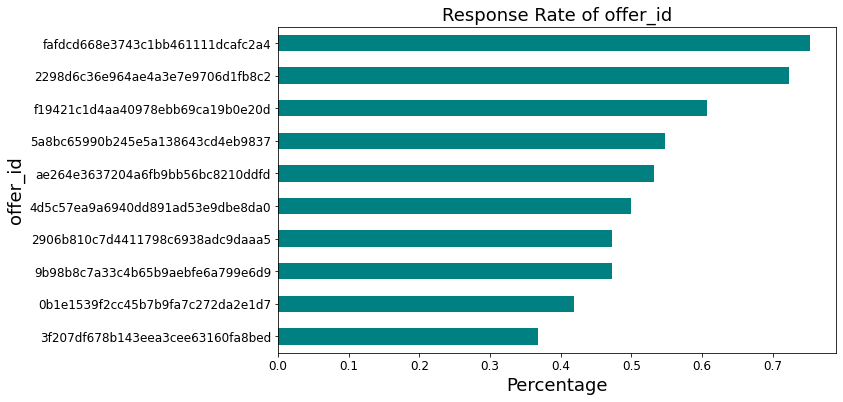

In [111]:
# Plot distribution of response_rate
response_rate.sort_values(ascending=True).plot.barh(figsize=(10,6), fontsize=12,color='teal');
plt.xlabel('Percentage', fontsize=18)
plt.ylabel('offer_id', fontsize=18)
plt.title('Response Rate of offer_id', fontsize=18)
plt.show()

In [112]:
offer_high_resp = portfolio[portfolio['offer_id'] == 'fafdcd668e3743c1bb461111dcafc2a4']
offer_high_resp

,offer_id,difficulty,duration,reward,bogo,discount,informational,web,email,mobile,social
6,fafdcd668e3743c1bb461111dcafc2a4,10,240,2,0,1,0,1,1,1,1


In [113]:
offer_low_resp = portfolio[portfolio['offer_id'] == '3f207df678b143eea3cee63160fa8bed']
offer_low_resp

,offer_id,difficulty,duration,reward,bogo,discount,informational,web,email,mobile,social
2,3f207df678b143eea3cee63160fa8bed,0,96,0,0,0,1,1,1,1,0


In [114]:
offer_id_high_resp = offer_high_resp['offer_id'].values[0]
offer_id_high_resp

'fafdcd668e3743c1bb461111dcafc2a4'

In [115]:
offer_id_low_resp = offer_low_resp['offer_id'].values[0]
offer_id_low_resp

'3f207df678b143eea3cee63160fa8bed'

In [116]:
combined_data_high_resp_df = combined_data_df.loc[combined_data_df['offer_id'] == offer_id_high_resp,:]
combined_data_low_resp_df = combined_data_df.loc[combined_data_df['offer_id'] == offer_id_low_resp,:]

cust_responded_high_rep_df = combined_data_high_resp_df.loc[combined_data_high_resp_df['cust_response'] == 1,:]
cust_not_responded_high_rep_df = combined_data_high_resp_df.loc[combined_data_high_resp_df['cust_response'] == 0,:]

In [117]:
round(cust_responded_high_rep_df[['F', 'M', 'O']].mean()*100,2)

F    44.18
M    54.52
O     1.30
dtype: float64

In [118]:
round(cust_not_responded_high_rep_df[['F', 'M', 'O']].mean()*100,2)

F    29.45
M    69.15
O     1.39
dtype: float64

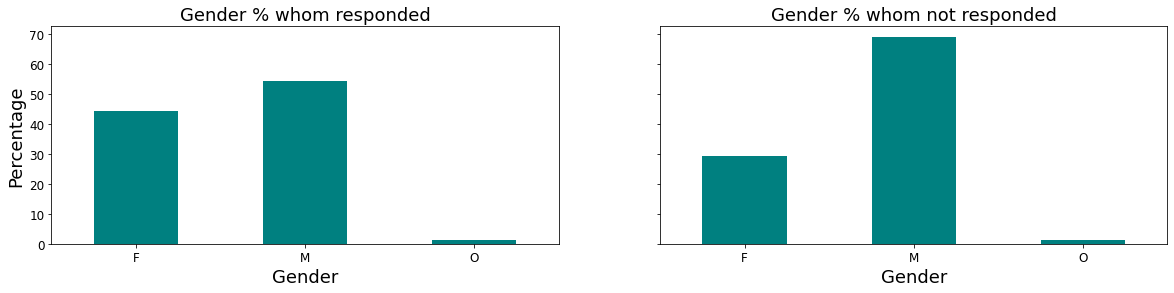

In [119]:
fig, ax = plt.subplots(figsize=(20, 6),
                       nrows=1,
                       ncols=2,
                       sharex=True,
                       sharey=True)

plt.subplot(121)
round(cust_responded_high_rep_df[['F', 'M', 'O']].mean()*100,2).plot.bar(figsize=(20,4), fontsize=12,color='teal');
plt.xlabel('Gender', fontsize=18)
plt.xticks(rotation='horizontal')
plt.ylabel('Percentage', fontsize=18)
plt.title('Gender % whom responded', fontsize=18)


plt.subplot(122)
round(cust_not_responded_high_rep_df[['F', 'M', 'O']].mean()*100,2).plot.bar(figsize=(20,4), fontsize=12,color='teal');
plt.xlabel('Gender', fontsize=18)
plt.xticks(rotation='horizontal')
plt.ylabel('Percentage', fontsize=18)
plt.title('Gender % whom not responded', fontsize=18)

plt.show()

In [120]:
age_grp_list = ['age_10s', 'age_20s', 'age_30s', 'age_40s', 'age_50s', 'age_60s', 'age_70s', 'age_80s', 'age_90s', 'age_100s']
round(cust_responded_high_rep_df[age_grp_list].mean()*100,2)

age_10s      0.96
age_20s      8.24
age_30s     10.34
age_40s     14.77
age_50s     24.99
age_60s     21.39
age_70s     11.58
age_80s      5.84
age_90s      1.68
age_100s     0.22
dtype: float64

In [121]:
round(cust_not_responded_high_rep_df[age_grp_list].mean()*100,2)

age_10s      1.94
age_20s     12.73
age_30s     10.97
age_40s     17.33
age_50s     19.58
age_60s     19.64
age_70s     12.00
age_80s      4.12
age_90s      1.58
age_100s     0.12
dtype: float64

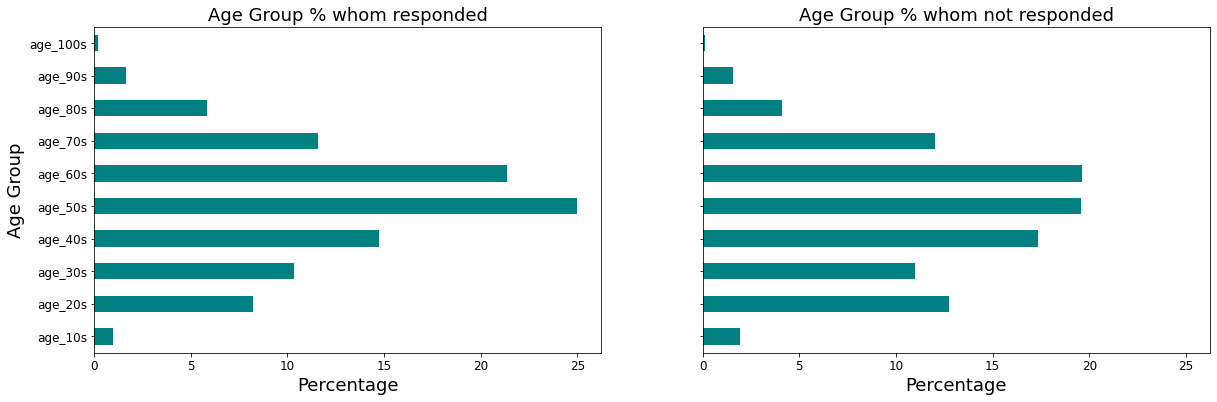

In [122]:
fig, ax = plt.subplots(figsize=(20, 6),
                       nrows=1,
                       ncols=2,
                       sharex=True,
                       sharey=True)

plt.subplot(121)
round(cust_responded_high_rep_df[age_grp_list].mean()*100,2).plot.barh(figsize=(20,6), fontsize=12,color='teal');
plt.xlabel('Percentage', fontsize=18)
#plt.xticks(rotation='horizontal')
plt.ylabel('Age Group', fontsize=18)
plt.title('Age Group % whom responded', fontsize=18)


plt.subplot(122)
round(cust_not_responded_high_rep_df[age_grp_list].mean()*100,2).plot.barh(figsize=(20,6), fontsize=12,color='teal');
plt.xlabel('Percentage', fontsize=18)
#plt.xticks(rotation='horizontal')
plt.ylabel('Age Group', fontsize=18)
plt.title('Age Group % whom not responded', fontsize=18)

plt.show()

In [123]:
income_grp_list = ['income_30ths', 'income_40ths', 'income_50ths', 'income_60ths','income_70ths', 'income_80ths',\
                   'income_90ths', 'income_100ths', 'income_110ths', 'income_120ths']
round(cust_responded_high_rep_df[income_grp_list].mean()*100,2)

KeyError: "None of [Index(['income_30ths', 'income_40ths', 'income_50ths', 'income_60ths',\n       'income_70ths', 'income_80ths', 'income_90ths', 'income_100ths',\n       'income_110ths', 'income_120ths'],\n      dtype='object')] are in the [columns]"

In [ ]:
round(cust_not_responded_high_rep_df[income_grp_list].mean()*100,2)

In [ ]:
fig, ax = plt.subplots(figsize=(20, 6),
                       nrows=1,
                       ncols=2,
                       sharex=True,
                       sharey=True)

plt.subplot(121)
round(cust_responded_high_rep_df[income_grp_list].mean()*100,2).plot.barh(figsize=(20,6), fontsize=12,color='teal');
plt.xlabel('Percentage', fontsize=18)
#plt.xticks(rotation='horizontal')
plt.ylabel('Income Group', fontsize=18)
plt.title('Income Group % whom responded', fontsize=18)


plt.subplot(122)
round(combined_data_low_resp_df[income_grp_list].mean()*100,2).plot.barh(figsize=(20,6), fontsize=12,color='teal');
plt.xlabel('Percentage', fontsize=18)
#plt.xticks(rotation='horizontal')
plt.ylabel('Income Group', fontsize=18)
plt.title('Income Group % whom not responded', fontsize=18)

plt.show()

### Split the combined data into training and test data

In [125]:
combined_data_df.drop(columns=['customer_id', 'offer_id', 'time'], inplace=True)
combined_data_df.head()

,difficulty,duration,reward,membership_tenure,F,M,O,age_10s,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_80s,age_90s,age_100s,total_amount,cust_response
0,5,168,5,1636,1,0,0,0,0,0,0,0,0,1,0,0,0,37.67,1
1,0,72,0,1636,1,0,0,0,0,0,0,0,0,1,0,0,0,49.39,1
2,10,168,10,1636,1,0,0,0,0,0,0,0,0,1,0,0,0,48.28,1
3,5,120,5,1636,1,0,0,0,0,0,0,0,0,1,0,0,0,48.28,1
4,10,168,2,1284,0,1,0,0,0,0,0,0,1,0,0,0,0,0.00,0


In [126]:
X = combined_data_df.drop(columns=['cust_response'])
y = combined_data_df.loc[:,['cust_response']]

In [127]:
y.squeeze().value_counts()

1    35854
0    30647
Name: cust_response, dtype: int64

In [128]:
round((y.squeeze().value_counts()/y.squeeze().count())*100,2)

1    53.91
0    46.09
Name: cust_response, dtype: float64

In [129]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [130]:
X_train.head()

,difficulty,duration,reward,membership_tenure,F,M,O,age_10s,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_80s,age_90s,age_100s,total_amount
3422,0,96,0,2295,0,1,0,0,0,0,0,1,0,0,0,0,0,3.21
64365,10,168,10,1682,0,1,0,0,0,0,0,0,1,0,0,0,0,109.55
64981,10,168,2,1386,0,1,0,0,0,0,0,0,0,0,1,0,0,87.60
59855,5,120,5,1876,0,0,1,0,1,0,0,0,0,0,0,0,0,55.47
27439,0,72,0,2271,0,1,0,0,0,0,0,0,0,0,1,0,0,46.86


### Scale selected features

In [131]:
feat_to_scale = ['difficulty', 'duration', 'reward', 'membership_tenure', 'total_amount']

In [132]:
def func_feat_scale(df, feat=feat_to_scale):
        """
    Scale list features in a given dataframe
    
    INPUT:
    - df (dataframe): dataframe having features to scale
    - feat (list): list of features in dataframe to scale
            
    OUTPUT:
    - scaled_df (dataframe): dataframe containing scaled features
    """
        # Prepare dataframe of only features to scale
        df_feat_scale = df.loc[:,feat]
        
        # Apply feature scaling to df
        scaler = MinMaxScaler()
        df_feat_scale = pd.DataFrame(scaler.fit_transform(df_feat_scale), columns = df_feat_scale.columns,\
                                     index=df_feat_scale.index)
        
        # Drop orignal features to scale from df and add scaled features back to df
        df = df.drop(columns=feat, axis=1)
        df_scaled = pd.concat([df, df_feat_scale], axis=1)
        
        return df_scaled

In [133]:
X_train_scaled = func_feat_scale(X_train, feat=feat_to_scale)
X_train_scaled.head()

,F,M,O,age_10s,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_80s,age_90s,age_100s,difficulty,duration,reward,membership_tenure,total_amount
3422,0,1,0,0,0,0,0,1,0,0,0,0,0,0.00,0.142857,0.0,0.604498,0.002862
64365,0,1,0,0,0,0,0,0,1,0,0,0,0,0.50,0.571429,1.0,0.268239,0.097662
64981,0,1,0,0,0,0,0,0,0,0,1,0,0,0.50,0.571429,0.2,0.105869,0.078094
59855,0,0,1,0,1,0,0,0,0,0,0,0,0,0.25,0.285714,0.5,0.374657,0.049450
27439,0,1,0,0,0,0,0,0,0,0,1,0,0,0.00,0.000000,0.0,0.591333,0.041775


In [134]:
X_train_scaled.shape

(49875, 18)

In [135]:
y_train.shape

(49875, 1)

In [136]:
y_train.squeeze().value_counts()

1    26834
0    23041
Name: cust_response, dtype: int64

In [137]:
round((y_train.squeeze().value_counts()/y_train.squeeze().count())*100,2)

1    53.8
0    46.2
Name: cust_response, dtype: float64

## Train the classifier

In [138]:
#baseline model to compare

baseline_model_f1_score = f1_score(y_train.squeeze().values, np.ones(y_train.shape[0]))
print('baseline model have f1_score: {}'.format(round(baseline_model_f1_score,4)))

baseline model have f1_score: 0.6996


In [139]:
def fit_classifier(clf, param_grid, X=X_train_scaled.values, y=y_train.squeeze().values):
    """
    Fits a classifier to its training data using GridSearchCV and calculates f1_score
    
    INPUT:
    - clf (classifier): classifier to fit
    - param_grid (dict): classifier parameters used with GridSearchCV
    - X_train_scaled (DataFrame): training features
    - y_train (DataFrame): training label
            
    OUTPUT:
    - classifier: input classifier fitted to the training data
    """
    
    # cv uses StratifiedKFold
    # scoring f1 available as parameter
    start = time.time()
    grid = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='f1', cv=5, verbose=0)
    print("Training {} :".format(clf.__class__.__name__))
    grid.fit(X, y)
    end = time.time()
    time_taken = round(end-start,2)

    print(clf.__class__.__name__)
    print("Time taken : {} secs".format(time_taken))
    print("Best f1_score : {}".format(round(grid.best_score_,4)))
    print("*"*40)
    
    return grid.best_score_, grid.best_estimator_, time_taken

In [140]:
lor = LogisticRegression(random_state=42,solver='lbfgs', max_iter=1000) # LogisticRegression
rfc = RandomForestClassifier(random_state=42) # RandomForestClassifier
abc = AdaBoostClassifier(random_state=42) # AdaBoostClassifier
gbc = GradientBoostingClassifier(random_state=42) # GradientBoostingClassifier

In [141]:
# Find best classification algorithm
clf_names = []
clf_scores = []
clf_best_ests = []
clf_time_taken = []
clf_dict = {}

for clf in [lor, rfc, abc, gbc]:
    best_score, best_est, time_taken = fit_classifier(clf, {})
    clf_names.append(clf.__class__.__name__)
    clf_scores.append(best_score)
    clf_best_ests.append(best_est)
    clf_time_taken.append(time_taken)

Training LogisticRegression :
LogisticRegression
Time taken : 2.18 secs
Best f1_score : 0.8343
****************************************
Training RandomForestClassifier :
RandomForestClassifier
Time taken : 21.03 secs
Best f1_score : 0.927
****************************************
Training AdaBoostClassifier :
AdaBoostClassifier
Time taken : 9.57 secs
Best f1_score : 0.8962
****************************************
Training GradientBoostingClassifier :
GradientBoostingClassifier
Time taken : 29.97 secs
Best f1_score : 0.9204
****************************************


In [142]:
clf_dict['best_f1_score'] = clf_scores
clf_dict['time_taken(s)'] = clf_time_taken
clf_dict['best_est'] = clf_best_ests
clf_df = pd.DataFrame(clf_dict, index=clf_names)
clf_df

,best_f1_score,time_taken(s),best_est
LogisticRegression,0.834258,2.18,"LogisticRegression(max_iter=1000, random_state..."
RandomForestClassifier,0.927038,21.03,"(DecisionTreeClassifier(max_features='auto', r..."
AdaBoostClassifier,0.896218,9.57,"(DecisionTreeClassifier(max_depth=1, random_st..."
GradientBoostingClassifier,0.920424,29.97,([DecisionTreeRegressor(criterion='friedman_ms...


In [143]:
clf_df.loc['RandomForestClassifier', 'best_est']

RandomForestClassifier(random_state=42)

In [144]:
#fine tune the model
param_grid = {#'n_estimators': [10, 50, 80, 100],
              'n_estimators': [500],
              #'max_depth': [None, 2, 3, 4],
              'max_depth': [None],
              #'min_samples_split': [2,3,4],
              'min_samples_split': [4],
              #'min_samples_leaf': [1,2,3],
              'min_samples_leaf': [1]
             }

rfc = RandomForestClassifier(random_state=42)
rfc_best_score, rfc_best_est, _ = fit_classifier(rfc, param_grid)
rfc_best_est

Training RandomForestClassifier :
RandomForestClassifier
Time taken : 119.0 secs
Best f1_score : 0.9287
****************************************


RandomForestClassifier(min_samples_split=4, n_estimators=500, random_state=42)

RandomForestClassifier(min_samples_split=4, n_estimators=500, random_state=42)

In [160]:
model = rfc_best_est

### Feature Importances given by best estimator of trained model

In [145]:
# Prepare the dataframe of feature importances given to features by best estimator of RandomForestClassifier
feat_imp_df = pd.DataFrame(rfc_best_est.feature_importances_,\
                           index=X_train_scaled.columns.tolist(),\
                           columns=['feat_imp']).reset_index()

feat_imp_df.rename(columns={'index': 'feature'}, inplace=True)
feat_imp_df['feat_imp_perc'] = np.round((feat_imp_df['feat_imp']/feat_imp_df['feat_imp'].sum())*100,2)
feat_imp_df = feat_imp_df.sort_values(by=['feat_imp_perc'], ascending=False).reset_index(drop=True)
feat_imp_df

,feature,feat_imp,feat_imp_perc
0,total_amount,0.731929,73.19
1,membership_tenure,0.146169,14.62
2,duration,0.034212,3.42
3,difficulty,0.029946,2.99
4,reward,0.023797,2.38
5,M,0.005469,0.55
6,F,0.004387,0.44
7,age_20s,0.003519,0.35
8,age_50s,0.003141,0.31
9,age_30s,0.002953,0.30


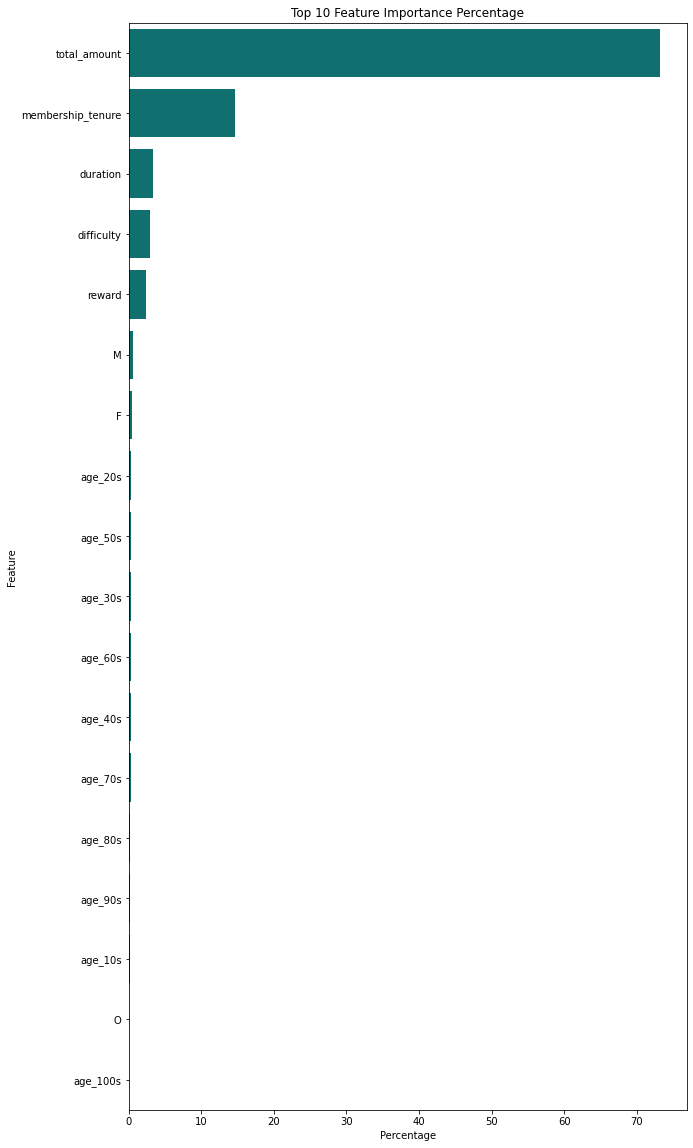

In [146]:
fig, ax = plt.subplots(figsize=(10, 20),
                       nrows=1,
                       ncols=1)

sns.barplot(x='feat_imp_perc', y='feature', color='teal', data=feat_imp_df)
plt.xlabel('Percentage')
#plt.xticks(rotation='horizontal')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importance Percentage')
plt.show()

In [147]:
# Print top 10 features
feat_imp_df[:10]

,feature,feat_imp,feat_imp_perc
0,total_amount,0.731929,73.19
1,membership_tenure,0.146169,14.62
2,duration,0.034212,3.42
3,difficulty,0.029946,2.99
4,reward,0.023797,2.38
5,M,0.005469,0.55
6,F,0.004387,0.44
7,age_20s,0.003519,0.35
8,age_50s,0.003141,0.31
9,age_30s,0.002953,0.30


### Predict classes for the test data

In [148]:
X_test_scaled = func_feat_scale(X_test, feat=feat_to_scale)
X_test_scaled.head()

,F,M,O,age_10s,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_80s,age_90s,age_100s,difficulty,duration,reward,membership_tenure,total_amount
20034,0,1,0,0,0,0,1,0,0,0,0,0,0,0.25,0.571429,0.5,0.503017,0.004838
55752,0,1,0,0,0,0,1,0,0,0,0,0,0,0.50,0.571429,1.0,0.815688,0.016028
61495,0,1,0,0,0,0,0,1,0,0,0,0,0,0.25,0.285714,0.5,0.399342,0.016362
34391,0,1,0,0,0,1,0,0,0,0,0,0,0,0.25,0.285714,0.5,0.116292,0.000000
36619,0,1,0,0,0,0,0,0,1,0,0,0,0,0.25,0.285714,0.5,0.149205,0.000669


In [149]:
y_pred = rfc_best_est.predict(X_test_scaled)
y_pred

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


array([0, 1, 1, ..., 0, 0, 1], dtype=int64)

In [150]:
y_pred.shape

(16626,)

### Confusion Matrix

In [151]:
confusion_matrix(y_test.squeeze().values, y_pred)

array([[6645,  961],
       [ 423, 8597]], dtype=int64)

In [152]:
tn, fp, fn, tp = confusion_matrix(y_test.squeeze().values, y_pred).ravel()
print('true negatives: {}'.format(tn))
print('false postives: {}'.format(fp))
print('false negatives: {}'.format(fn))
print('true postives: {}'.format(tp))

true negatives: 6645
false postives: 961
false negatives: 423
true postives: 8597


In [153]:
# Calculate precision, recall and f1_score of the test data
test_data_f1_score = f1_score(y_test.squeeze().values, y_pred)
test_data_precision_score = precision_score(y_test.squeeze().values.tolist(), y_pred)
test_data_recall_score = recall_score(y_test.squeeze().values, y_pred)
print('f1_score on test data: {}'.format(round(test_data_f1_score,4)))
print('precision score on test data: {}'.format(round(test_data_precision_score,4)))
print('recall score on test data: {}'.format(round(test_data_recall_score,4)))

f1_score on test data: 0.9255
precision score on test data: 0.8995
recall score on test data: 0.9531


In [154]:
# Define function plot_confusion_matrix which plots confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    INPUT:
    - y_true (np.array): array containing true labels
    - y_pred (np.array): array containing predicted labels
    - normalize (boolean): boolean value to determine whether to normalize the confusion matrix or not
    - title (str): title to use in confusion matrix plot
            
    OUTPUT:
    - ax (Axes object): Axes object to plot confusion matrix plot
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=0, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization
[[6645  961]
 [ 423 8597]]


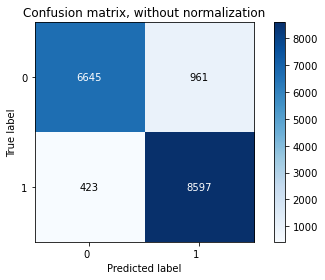

In [155]:
np.set_printoptions(precision=2)
class_names = np.array([0, 1])

plot_confusion_matrix(y_test.squeeze().values, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.show()

Normalized confusion matrix
[[0.87 0.13]
 [0.05 0.95]]


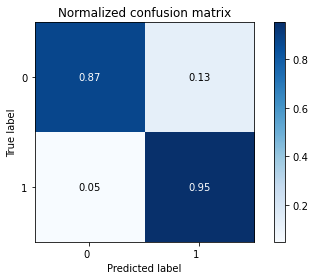

In [156]:
plot_confusion_matrix(y_test.squeeze().values, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [ ]:
rfc_best_est

In [157]:
import pickle

In [161]:
pickle.dump(model, open('model.pkl', 'wb'))

In [162]:
pickled_model = pickle.load(open('model.pkl', 'rb'))
pickled_model.predict(X_test)

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


array([1, 1, 1, ..., 0, 1, 1], dtype=int64)